In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

In [2]:
# read data
data = pd.read_csv('../data/US_Accidents_March23_sampled_500k.csv')
data.shape

(500000, 46)

# Section 1: General inspection of dataset

Let's see the variables in our data and decide which will we our target variable.

In [3]:
data.columns

Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

As explained, the target variable is 'Severity', this is how important, the gravity of the accident, in order to predict how does it affect the traffic.

First we take off some variables which we consider may not explain the target. Notice some of these variables are additional information if we alredy have the End_Lat and End_Lng, so we can take them off.

In [4]:
data = data.drop(columns=['ID', 'Source', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 
                          'Weather_Timestamp', 'End_Lat','End_Lng','Airport_Code','Wind_Chill(F)', 'Wind_Direction', 'Wind_Speed(mph)',
                          'Precipitation(in)', 'Weather_Condition', 'Bump', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',])
data.shape

(500000, 23)

We have reduced the number of variables from 46 to 23.

In [5]:
data.columns

Index(['Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Amenity', 'Crossing', 'Give_Way', 'Junction',
       'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Astronomical_Twilight'],
      dtype='object')

The Start_Time and End_Time variables cause some problems since they are strings and are difficult to compute. In order to avoid further problems we will create a new variable called Elapsed_Time, which will be the difference between End_Time and Start_Time.

In [6]:
data['Start_Time'].isna().sum()

0

In [7]:
data['End_Time'].isna().sum()

0

These two variables do not present any Nan, so we can proceed creating this new variable.

In [8]:
time_elapsed: list[int] = list()

for start_time, end_time in zip(data['Start_Time'], data['End_Time']):

    start_time = start_time.split('.')[0]
    end_time = end_time.split('.')[0]

    start = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
    end = datetime.strptime(end_time, '%Y-%m-%d %H:%M:%S')
    time_elapsed.append((end-start).seconds)

data['Time_Difference'] = pd.DataFrame(time_elapsed)

data['Start_Time'] = pd.to_datetime(data['Start_Time'], errors = 'coerce')
data['End_Time'] = pd.to_datetime(data['End_Time'], errors = 'coerce')

data['Year'] = data['Start_Time'].dt.year
data['Month'] = data['Start_Time'].dt.month
data['Day'] = data['Start_Time'].dt.day
data['Hour'] = data['Start_Time'].dt.hour
data['Weekday'] = data['Start_Time'].dt.weekday

print(data['Day'])

data.shape

0         12
1          3
2         20
3         21
4          4
          ..
499995    15
499996    19
499997    13
499998    15
499999     2
Name: Day, Length: 500000, dtype: int64


(500000, 29)

Now that we have this information in this new variable, we can take off 'Start_Time' and 'End_Time'.

In [9]:
data_w_c = data.drop(columns=['Start_Time', 'End_Time'])
data_w_c.shape

(500000, 27)

# Section 2: Dealing with missing values

Let's see the summary of our dataset now in order to Identify possibles Nan's.

In [10]:
data_w_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Severity               500000 non-null  int64  
 1   Start_Lat              500000 non-null  float64
 2   Start_Lng              500000 non-null  float64
 3   Distance(mi)           500000 non-null  float64
 4   Temperature(F)         489534 non-null  float64
 5   Humidity(%)            488870 non-null  float64
 6   Pressure(in)           491072 non-null  float64
 7   Visibility(mi)         488709 non-null  float64
 8   Amenity                500000 non-null  bool   
 9   Crossing               500000 non-null  bool   
 10  Give_Way               500000 non-null  bool   
 11  Junction               500000 non-null  bool   
 12  No_Exit                500000 non-null  bool   
 13  Railway                500000 non-null  bool   
 14  Roundabout             500000 non-nu

The target value severity is categorical and Python identifies it as an int, so lets correct this. Also for the bool variables, let's make them an object. For a better visualization of the data, it follows the graphic

In [11]:
data_w_c.Severity = data_w_c.Severity.astype('object')
for column in ['Amenity', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop','Month','Weekday','Day']:
    data_w_c[column] = data_w_c[column].astype('object')

In [12]:
data_w_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Severity               500000 non-null  object 
 1   Start_Lat              500000 non-null  float64
 2   Start_Lng              500000 non-null  float64
 3   Distance(mi)           500000 non-null  float64
 4   Temperature(F)         489534 non-null  float64
 5   Humidity(%)            488870 non-null  float64
 6   Pressure(in)           491072 non-null  float64
 7   Visibility(mi)         488709 non-null  float64
 8   Amenity                500000 non-null  object 
 9   Crossing               500000 non-null  object 
 10  Give_Way               500000 non-null  object 
 11  Junction               500000 non-null  object 
 12  No_Exit                500000 non-null  object 
 13  Railway                500000 non-null  object 
 14  Roundabout             500000 non-nu

First we will compute the missing values for categorical variables and then for the continuous.

In [13]:
data_w_c.describe(include=['O'])

,Severity,Amenity,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Astronomical_Twilight,Month,Day,Weekday
count,500000,500000,500000,500000,500000,500000,500000,500000,500000,500000,500000,500000,500000,498517,500000,500000,500000
unique,4,2,2,2,2,2,2,2,2,2,2,2,1,2,12,31,7
top,2,False,False,False,False,False,False,False,False,False,False,False,False,Day,12,23,4
freq,398142,493809,443747,497638,462993,498755,495680,499987,487002,485937,499534,425965,500000,412242,54589,18159,88766


It does not seem to be any missing value for the categorical values of the dataset, using the information available from the description. There are some Nan's, but these are detected by Python, so for the moment there is anything to worry about.

Now let's do the same for numerical variables.

In [14]:
data_w_c.describe(include=['int', 'float'])

,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Time_Difference,Year,Hour
count,500000.000000,500000.000000,500000.000000,489534.000000,488870.000000,491072.000000,488709.000000,500000.000000,500000.000000,500000.000000
mean,36.206421,-94.736583,0.564317,61.646254,64.834921,29.536621,9.091540,6532.913214,2019.906596,12.321320
std,5.071411,17.405761,1.774872,19.000133,22.826158,1.008666,2.708083,7566.691113,1.913944,5.471098
min,24.562117,-124.497420,0.000000,-77.800000,1.000000,0.120000,0.000000,0.000000,2016.000000,0.000000
25%,33.416823,-117.233047,0.000000,49.000000,48.000000,29.370000,10.000000,1890.000000,2018.000000,8.000000
50%,35.832147,-87.794365,0.029000,64.000000,67.000000,29.860000,10.000000,4488.000000,2020.000000,13.000000
75%,40.082443,-80.359601,0.465000,76.000000,84.000000,30.030000,10.000000,7485.000000,2022.000000,17.000000
max,48.999569,-67.484130,193.479996,207.000000,100.000000,38.440000,130.000000,86399.000000,2023.000000,23.000000


The Distance variable contains some 0's, it cannot be since if there has been an accident, the lenght of the road affected by it is greater than 0. The temperature of 200 F is not possible here, so it is also a Nan, the same with temperatures smaller then -40 F.The humidity percentage contains some 1, it is very low and cannot be real so we compute it as a missing value, the same for one of 100%. The minimum of the pressure (0.12 in) is very low for a place in the Earth, so there are also missing values there. A visibility of 0 miles is also a missing value, although it could be due to a climatological adversity, the same for 130 miles.

<AxesSubplot: >

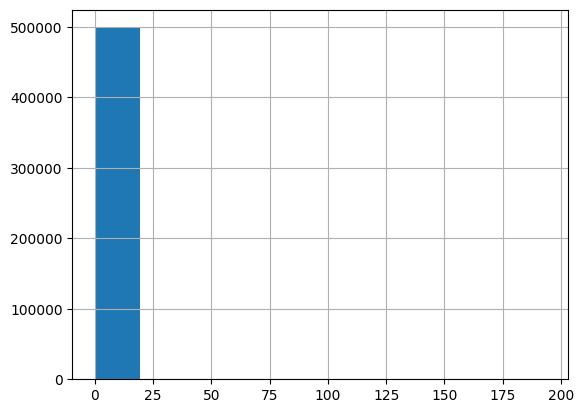

In [15]:
data_w_c['Distance(mi)'].hist()

<AxesSubplot: >

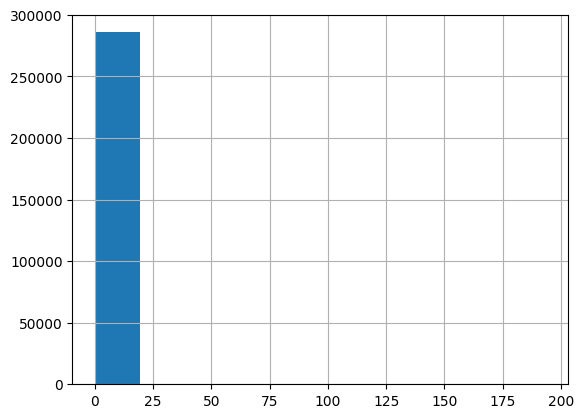

In [16]:
data_w_c['Distance(mi)'][(data_w_c['Distance(mi)'] != 0)].hist()

<AxesSubplot: >

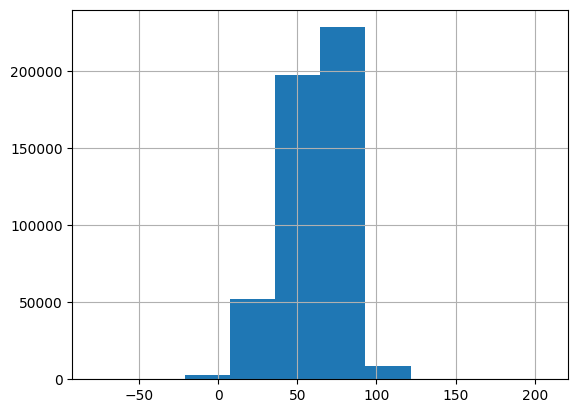

In [17]:
data_w_c['Temperature(F)'].hist()

<AxesSubplot: >

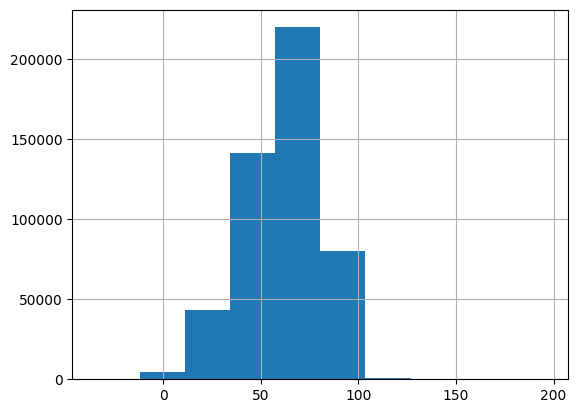

In [18]:
data_w_c['Temperature(F)'][(data_w_c['Temperature(F)'] <= 200)&(data_w_c['Temperature(F)'] > -50)].hist()

<AxesSubplot: >

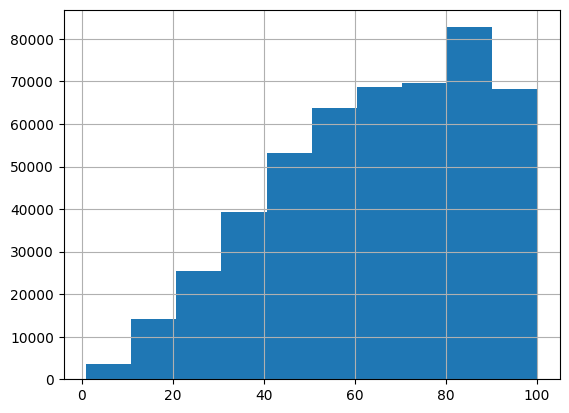

In [19]:
data_w_c['Humidity(%)'].hist()

<AxesSubplot: >

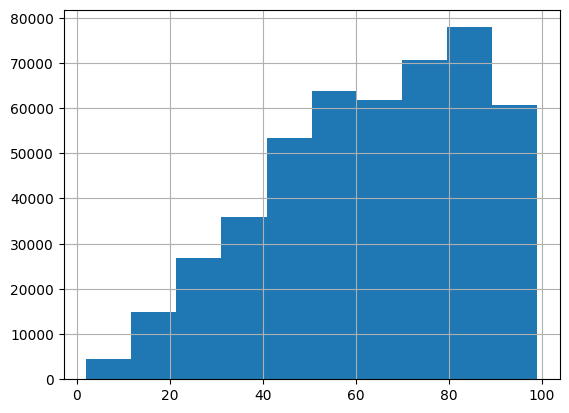

In [20]:
data_w_c['Humidity(%)'][(data_w_c['Humidity(%)'] !=1)&(data_w_c['Humidity(%)'] != 100)].hist()

<AxesSubplot: >

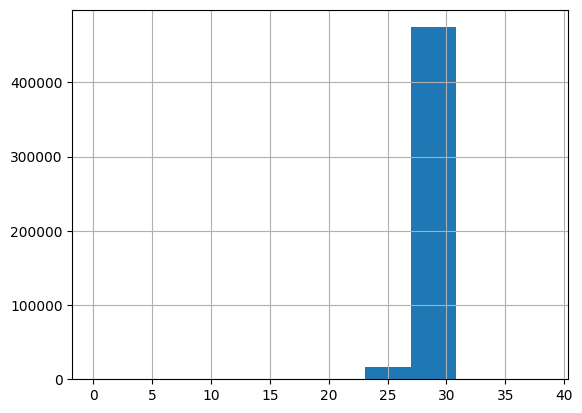

In [21]:
data_w_c['Pressure(in)'].hist()

<AxesSubplot: >

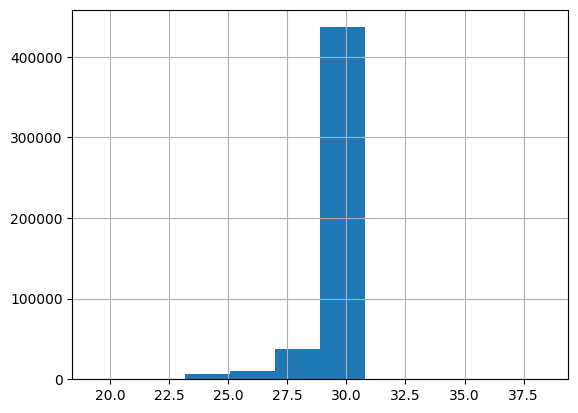

In [22]:
data_w_c['Pressure(in)'][(data_w_c['Pressure(in)'] > 3)].hist()

<AxesSubplot: >

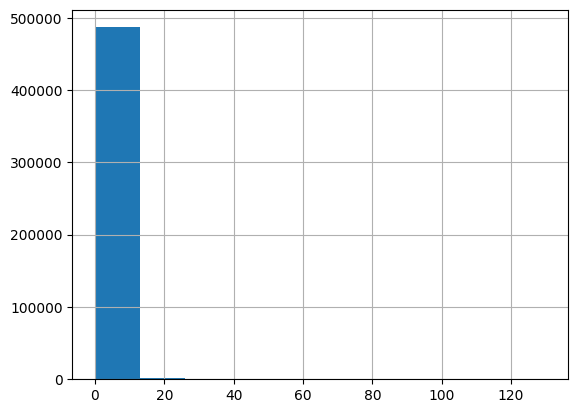

In [23]:
data_w_c['Visibility(mi)'].hist()

<AxesSubplot: >

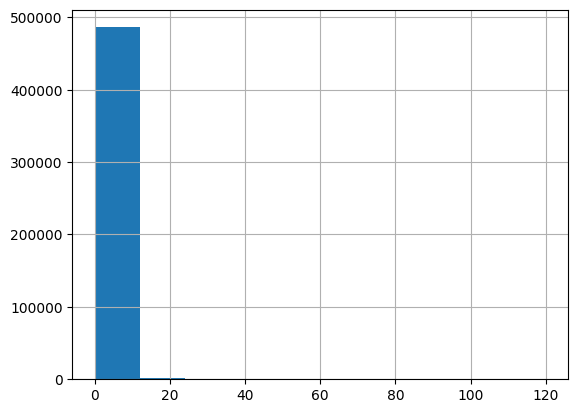

In [24]:
data_w_c['Visibility(mi)'][(data_w_c['Visibility(mi)'] != 0) & (data_w_c['Visibility(mi)'] != 130)].hist()

In [25]:
((data_w_c['Visibility(mi)'] == 0) | (data_w_c['Visibility(mi)'] == 130)).value_counts()

False    499481
True        519
Name: Visibility(mi), dtype: int64

We set the 300 mph bound because it is the aproximately point of the wind's speed in a hurricane.

Now that we have seen some missing values in our data, we will set no NA the values seen here in order to impute a prediction using the KNN algorithm.

In [26]:
data_w_c['Distance(mi)'][(data_w_c['Distance(mi)'] == 0)] = np.nan
data_w_c['Temperature(F)'][(data_w_c['Temperature(F)'] >= 200)|(data_w_c['Temperature(F)'] <= -50)] = np.nan
data_w_c['Humidity(%)'][(data_w_c['Humidity(%)'] == 1)|(data_w_c['Humidity(%)'] == 100)] = np.nan
data_w_c['Pressure(in)'][(data_w_c['Pressure(in)'] < 3)] = np.nan
data_w_c['Visibility(mi)'][(data_w_c['Visibility(mi)'] == 0)|(data_w_c['Visibility(mi)'] == 130)] = np.nan

/tmp/ipykernel_25395/3770805335.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_w_c['Distance(mi)'][(data_w_c['Distance(mi)'] == 0)] = np.nan
/tmp/ipykernel_25395/3770805335.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_w_c['Temperature(F)'][(data_w_c['Temperature(F)'] >= 200)|(data_w_c['Temperature(F)'] <= -50)] = np.nan
/tmp/ipykernel_25395/3770805335.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_w_c['H

Let's see the difference in the description table of the numerical variables of the dataset.

In [27]:
data_w_c.describe(include=['int', 'float'])

,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Time_Difference,Year,Hour
count,500000.000000,500000.000000,286413.000000,489532.000000,470461.000000,491070.000000,488190.000000,500000.000000,500000.000000,500000.000000
mean,36.206421,-94.736583,0.985146,61.646242,63.459133,29.536735,9.100939,6532.913214,2019.906596,12.321320
std,5.071411,17.405761,2.254945,18.997991,22.161575,1.007082,2.687707,7566.691113,1.913944,5.471098
min,24.562117,-124.497420,0.001000,-35.000000,2.000000,19.360000,0.060000,0.000000,2016.000000,0.000000
25%,33.416823,-117.233047,0.089000,49.000000,47.000000,29.370000,10.000000,1890.000000,2018.000000,8.000000
50%,35.832147,-87.794365,0.344000,64.000000,66.000000,29.860000,10.000000,4488.000000,2020.000000,13.000000
75%,40.082443,-80.359601,1.005000,76.000000,82.000000,30.030000,10.000000,7485.000000,2022.000000,17.000000
max,48.999569,-67.484130,193.479996,196.000000,99.000000,38.440000,120.000000,86399.000000,2023.000000,23.000000


Now we have set no NAN all those values that we have considered to be something strange, we will impute these values using the KNN algorithm.

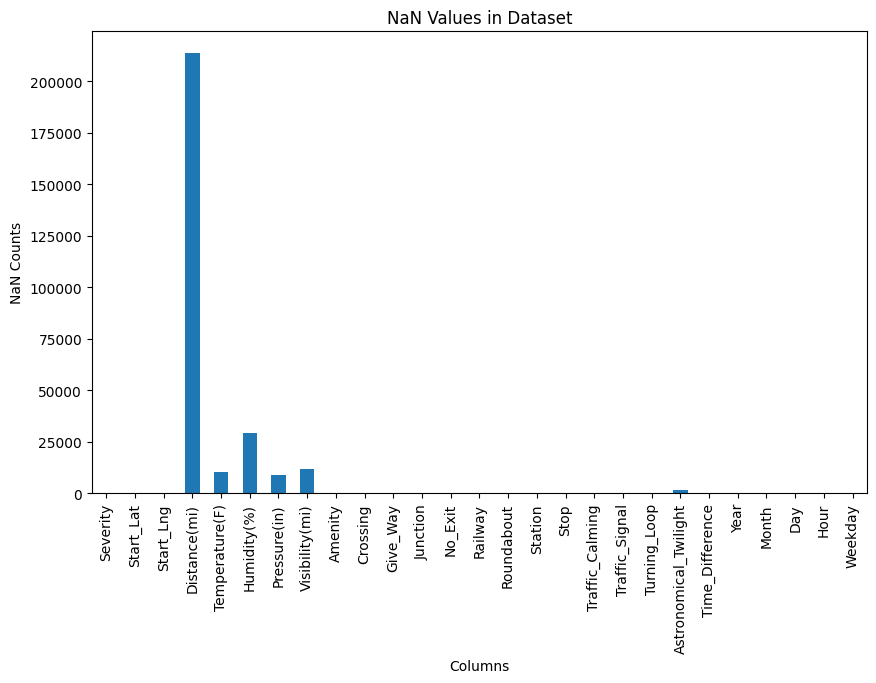

In [28]:
# nan histogram
nan_counts = data_w_c.isna().sum()
nan_counts.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Columns')
plt.ylabel('NaN Counts')
plt.title('NaN Values in Dataset')
plt.show()

In [29]:
columns_with_nan = ['Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)','Year','Month','Day','Hour','Weekday']
subset_data_w_c = data_w_c.drop(columns=columns_with_nan)

In [30]:
subset_data_w_c.shape

(500000, 17)

In [31]:
data_w_c.shape

(500000, 27)

In [32]:
rows_not_missing = data_w_c['Distance(mi)'].notna() & data_w_c['Temperature(F)'].notna() &  data_w_c['Humidity(%)'].notna() & data_w_c['Pressure(in)'].notna() & data_w_c['Visibility(mi)'].notna() & data_w_c['Year'].notna() & data_w_c['Month'].notna() & data_w_c['Day'].notna() & data_w_c['Hour'].notna() & data_w_c['Weekday'].notna()
data_w_c_without_missing = subset_data_w_c[rows_not_missing]
data_w_c_without_missing.shape

(267513, 17)

In [33]:
print(data_w_c['Hour'].dtype)

int64


In [34]:
#Seguir lo que se dice en el notebook 1 pre-processing
knn1 = KNeighborsRegressor(n_neighbors=1)
knn2 = KNeighborsClassifier(n_neighbors=1)

for column in columns_with_nan:
    
    rows_column_missing = subset_data_w_c[data_w_c[column].isna()]

    if data_w_c[column].dtype == 'float' or data_w_c[column].dtype == 'int':
        knn = knn1
    elif data_w_c[column].dtype == 'object':
        knn = knn2

    knn.fit(data_w_c_without_missing, data_w_c[column][rows_not_missing])
    imputed_values = knn.predict(rows_column_missing)

    data_w_c[column][data_w_c[column].isna()] = imputed_values

data_w_c.isna().sum()  

ValueError: could not convert string to float: 'Night'

In [ ]:
data_without_nan = data_w_c
data_without_nan.describe(include='all')

Our data has no Nan's, those who where have been imputated, now let's focus on the outliers.

FINDING OUTLIERS

It is important to identify these values, in order to take them into account when fitting models. Some of these models are sensitive to outliers. 

First let's see the variable Distance(mi), this has a clear outlier, it's max.

In [ ]:
fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data_without_nan.boxplot(column='Distance(mi)',ax=axes[0])
data_without_nan.hist(column='Distance(mi)',ax=axes[1])

There are obviously a lot of values that do not represent the correct distribution of our variable.

Let's use the IQR to improve this. Using LocalOutlierFactor, we have seen that it requires a lot of computational time and does not improve the results given by the IQR, so we will use this strategy.

In [ ]:
Q1 = data_without_nan['Distance(mi)'].quantile(0.25)
Q3 = data_without_nan['Distance(mi)'].quantile(0.75)
IQR = Q3 - Q1

small_out = data_without_nan['Distance(mi)'] < (Q1 - 1.5 * IQR)
big_out = data_without_nan['Distance(mi)'] > (Q3 + 1.5 * IQR)

fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data_without_nan[~(small_out | big_out)].boxplot(column='Distance(mi)',ax=axes[0])
data_without_nan[~(small_out | big_out)].hist(column='Distance(mi)',ax=axes[1])

In [ ]:
data_without_nan[~(small_out | big_out)].describe(include=['int', 'float']) 

In [ ]:
data_without_nan_out1 = data_without_nan[~(small_out | big_out)]

Visibility:

In [ ]:
fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data_without_nan_out1.boxplot(column='Visibility(mi)',ax=axes[0])
data_without_nan_out1.hist(column='Visibility(mi)',ax=axes[1])

In [ ]:
Q1 = data_without_nan_out1['Visibility(mi)'].quantile(0.25)
Q3 = data_without_nan_out1['Visibility(mi)'].quantile(0.75)
IQR = Q3 - Q1

small_out = data_without_nan_out1['Visibility(mi)'] < (Q1 - 1.5 * IQR)
big_out = data_without_nan_out1['Visibility(mi)'] > (Q3 + 1.5 * IQR)

fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data_without_nan_out1[~(small_out | big_out)].boxplot(column='Visibility(mi)',ax=axes[0])
data_without_nan_out1[~(small_out | big_out)].hist(column='Visibility(mi)',ax=axes[1])

All data from Visibility is concentrated around 10 mi.

In [ ]:
data_without_nan_out1[~(small_out | big_out)].describe(include=['int', 'float']) 

In [ ]:
data_without_nan_out2 = data_without_nan_out1[~(small_out | big_out)]

Temperature:

In [ ]:
fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data_without_nan_out2.boxplot(column='Temperature(F)',ax=axes[0])
data_without_nan_out2.hist(column='Temperature(F)',ax=axes[1])

It seems well distributed. However, it seems there are some outliers. We will do the same for Wind_Chill since from the describe of the dataset, it is almost equally distributed as temperature.

In [ ]:
Q1 = data_without_nan_out2['Temperature(F)'].quantile(0.25)
Q3 = data_without_nan_out2['Temperature(F)'].quantile(0.75)
IQR = Q3 - Q1

small_out = data_without_nan_out2['Temperature(F)'] < (Q1 - 1.5 * IQR)
big_out = data_without_nan_out2['Temperature(F)'] > (Q3 + 1.5 * IQR)

fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data_without_nan_out2[~(small_out | big_out)].boxplot(column='Temperature(F)',ax=axes[0])
data_without_nan_out2[~(small_out | big_out)].hist(column='Temperature(F)',ax=axes[1])

It is better now.

In [ ]:
data_without_nan_out2[~(small_out | big_out)].describe(include=['int', 'float']) 

In [ ]:
data_without_nan_out3 = data_without_nan_out2[~(small_out | big_out)]

Humidity:

In [ ]:
fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data_without_nan_out3.boxplot(column='Humidity(%)',ax=axes[0])
data_without_nan_out3.hist(column='Humidity(%)',ax=axes[1])

Humidity is well distributed.

Time_Difference:

In [ ]:
fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data_without_nan_out6.boxplot(column='Time_Difference',ax=axes[0])
data_without_nan_out6.hist(column='Time_Difference',ax=axes[1])

In [ ]:
Q1 = data_without_nan_out6['Time_Difference'].quantile(0.25)
Q3 = data_without_nan_out6['Time_Difference'].quantile(0.75)
IQR = Q3 - Q1

small_out = data_without_nan_out6['Time_Difference'] < (Q1 - 1.5 * IQR)
big_out = data_without_nan_out6['Time_Difference'] > (Q3 + 1.5 * IQR)

fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data_without_nan_out6[~(small_out | big_out)].boxplot(column='Time_Difference',ax=axes[0])
data_without_nan_out6[~(small_out | big_out)].hist(column='Time_Difference',ax=axes[1])

In [ ]:
data_without_nan_out6[~(small_out | big_out)].describe(include=['int', 'float'])

In [ ]:
data_without_nan_out = data_without_nan_out6[~(small_out | big_out)]

Every numerical variable has been treated from outliers.

GAUSSIANITY AND TRANSFORMATIONS

Let's see if every numerical variable is distributed with a gaussian.

## SECTION Y: NORMALIZATION

In [47]:
data_without_nan_out.describe(include=['int', 'float'])

NameError: name 'data_without_nan_out' is not defined

## SECTION x: SHUFFLING DATA

In [ ]:
np.random.seed(1234)
data_without_nan_out = data_without_nan_out.sample(frac=1).reset_index(drop=True)